<a href="https://colab.research.google.com/github/salmaannissa/PCVK-UAS-Kelompok7/blob/main/KELOMPOK_7_PCVK_SALMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Load Model for CNN**

In [ ]:
import numpy as np
import imutils
import cv2
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load saved network
load_network = load_model('/content/drive/MyDrive/MachineLearning/Quiz 2/Contoh hasil training model.unknown')

In [ ]:
# Check summary
load_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

## **Mencari Ukuran Cropped Image**

Text(0.5, 1.0, 'Cropped image')

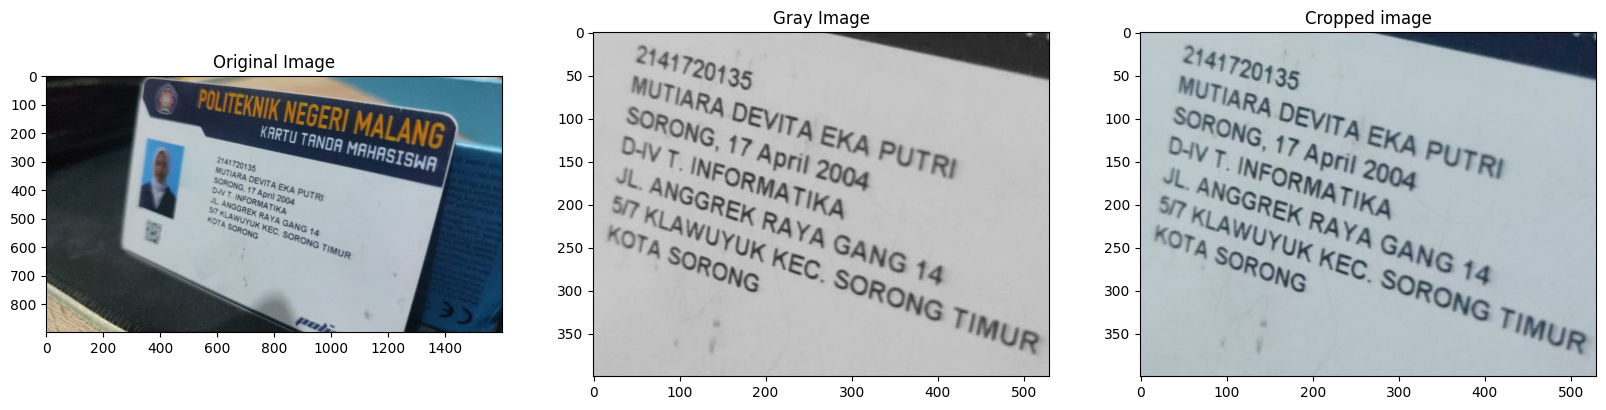

In [ ]:
img_find = cv2.imread('/content/drive/MyDrive/PCVK_KTM/3G_2141720135_5 - MUTIARA DEVITA EKA PUTRI.jpeg')

def rotate_image(image, angle, output_folder=None):
    # Get the height and width of the image
    height, width = image.shape[:2]

    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)

    # Determine the new dimensions of the rotated image
    cos_theta = np.abs(rotation_matrix[0, 0])
    sin_theta = np.abs(rotation_matrix[0, 1])
    new_width = int((height * sin_theta) + (width * cos_theta))
    new_height = int((height * cos_theta) + (width * sin_theta))

    # Adjust the rotation matrix for translation to keep the entire rotated image in view
    rotation_matrix[0, 2] += (new_width - width) / 2
    rotation_matrix[1, 2] += (new_height - height) / 2

    # Apply the rotation to the image with a dynamic border
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

    # Save the rotated image if output_folder is provided
    if output_folder:
        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        # Get the original image filename
        image_path = "path_to_your_original_image.jpg"  # Replace with the actual path to your original image
        filename = os.path.basename(image_path)

        # Generate the output path with the original filename and the desired file extension
        output_path = os.path.join(output_folder, f'rotated_{filename}.jpg')
        cv2.imwrite(output_path, rotated_image)

    return rotated_image

img_ori = cv2.cvtColor(img_find.copy(), cv2.COLOR_BGR2RGB)

def cutting(image, x, y, width, height):
    # Crop the region of interest from the image
    hasil = image[y:y+height, x:x+width]

    return hasil

# Tentukan koordinat untuk crop
x, y, width, height = 550, 270, 530, 400

img_crop = cutting(img_ori, x, y, width, height)

# img_rgb = cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB)

img_gray = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)

img_crp = cv2.cvtColor(img_crop.copy(), cv2.COLOR_BGR2RGB)
# blurred_image = cv2.GaussianBlur(img_gray, (1, 1), 0)

equalized_image = cv2.equalizeHist(img_gray)

img_gray = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_find, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img_gray, cv2.COLOR_BGR2RGB))
plt.title('Gray Image')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_crp, cv2.COLOR_BGR2RGB))
plt.title('Cropped image')

## **Fungsi untuk Mendeteksi Teks (OCR)**

In [ ]:
def process_contours(conts, invertion, img, min_w, max_w, min_h, max_h):
    img_copy = img.copy()

    for c in conts:
        (x, y, w, h) = cv2.boundingRect(c)

        if min_w <= w <= max_w and min_h <= h <= max_h:
            roi = invertion[y:y+h, x:x+w]
            # thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
            cv2_imshow(roi)  # Check

            cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Show bounding box on original image
    cv2_imshow(img_copy)

In [ ]:
def extract_roi(img, x, y, w, h, margin=2):
    roi = img[y - margin:y+h, x - margin:x + w + margin]
    return roi

In [ ]:
def resize_img(img, w, h):
    if w > h:
        resized = imutils.resize(img, width=28)
    else:
        resized = imutils.resize(img, height=28)

    print("Resized Image Shape:", resized.shape)  # Add this line

    # (w, h) = resized.shape
    (h, w) = resized.shape

    # Calculate how many pixels need to fill char image
    dX = int(max(0, 28 - w) / 2.0)
    dY = int(max(0, 28 - h) / 2.0)

    filled = cv2.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

    print("Filled Image Shape:", filled.shape)  # Add this line

    filled = cv2.resize(filled, (28, 28))

    return filled

In [ ]:
def normalization(img):
  img = img.astype('float32') / 255.0 # convert to floating point
  img = np.expand_dims(img, axis=-1) # add depth
  return img

In [ ]:
def process_box(img, x, y, w, h):
  roi = extract_roi(img, x, y, w, h)
  # thresh = thresholding(roi)
  (h, w) = roi.shape
  resized = resize_img(roi, w, h)

  cv2_imshow(resized)  # Show result

  normalized = normalization(resized)

  return (normalized, (x, y, w, h))

In [ ]:
def detect_characters(conts, gray, min_w, max_w, min_h, max_h):
    detected_char = []
    for c in conts:
        (x, y, w, h) = cv2.boundingRect(c)

        if min_w <= w <= max_w and min_h <= h <= max_h:
            detected_char.append(process_box(gray, x, y, w, h))

    return detected_char

In [ ]:
def find_contours(img):
  conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sort_contours(conts, method='left-to-right')[0]

  return conts

## **CITRA 1**
### **PREPROCESSING**

In [ ]:
def global_thresholding(image, threshold):
    binary = np.zeros_like(image)
    binary[image > threshold] = 255
    return binary
def cutting(image, x, y, width, height):
    # Crop the region of interest from the image
    hasil = image[y:y+height, x:x+width]
    return hasil
def preprocess_image_1(image_path):
    img = cv2.imread(image_path)
    # Display the original image
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Tentukan koordinat untuk crop
    x, y, width, height = 500, 200, 850, 500

    img = cutting(img, x, y, width, height)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.subplot(2, 3, 2)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    # Apply Global Threshold
    global_threshold = global_thresholding(gray, 135)
    plt.subplot(2, 3, 3)
    plt.imshow(global_threshold, cmap='gray')
    plt.title('Global Threshold')
    plt.axis('off')

    #Erosi the image
    erode_ktp = cv2.erode(global_threshold.copy(), cv2.getStructuringElement(cv2.MORPH_OPEN, (2, 2)))
    plt.subplot(2, 3, 4)
    plt.imshow(erode_ktp, cmap='gray')
    plt.title('Erosi Image')
    plt.axis('off')

    # Invert the image
    invertion = 255 - erode_ktp
    plt.subplot(2, 3, 5)
    plt.imshow(invertion, cmap='gray')
    plt.title('Invertion Image')
    plt.axis('off')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    return img, gray, invertion

### **SEGMENTASI**

In [ ]:
def ocr1(image_path):
    img, gray, invertion = preprocess_image_1(image_path)

    min_w, max_w = 3, 50
    min_h, max_h = 15, 50

    conts = find_contours(invertion.copy())
    process_contours(conts, invertion, img, min_w, max_w, min_h, max_h)

    detected_char = detect_characters(conts, invertion, min_w, max_w, min_h, max_h)

    pixels = np.array([px[0] for px in detected_char], dtype='float32')
    boxes = [box[1] for box in detected_char]

    digits = '0123456789'
    letters = 'ABCDEFGHIJKLMNOPQRSTUVWZYZ'
    char_list = digits + letters
    char_list = [ch for ch in char_list]

    print(char_list)

    # Predict
    preds = load_network.predict(pixels)

    preds.shape

    # Char Prediction
    for p in preds:
      char_idx = np.argmax(p)
      print(char_list[char_idx], end = " ")

    # Show char with actual image
    img_copy2 = img.copy()

    for(pred, (x, y, w, h)) in zip(preds, boxes):
      i = np.argmax(pred)
      char_detected = char_list[i]

      cv2.rectangle(img_copy2, (x, y), (x+w, y+h), (0,255,0), 2)
      cv2.putText(img_copy2, char_detected, (x - 10, y - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 2)

    cv2_imshow(img_copy2)

### **Penerapan OCR pada Citra 1**

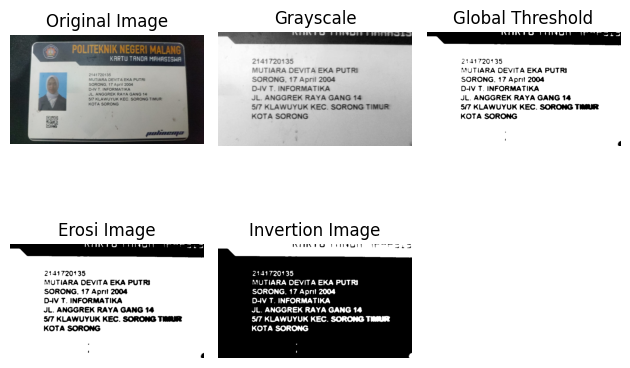

In [ ]:
img_p_01 = '/content/drive/MyDrive/PCVK_KTM/3G_2141720135_1 - MUTIARA DEVITA EKA PUTRI.jpeg'
Preprocess = preprocess_image_1(img_p_01)

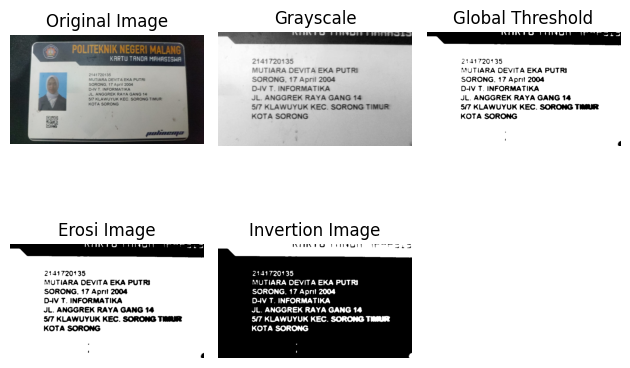

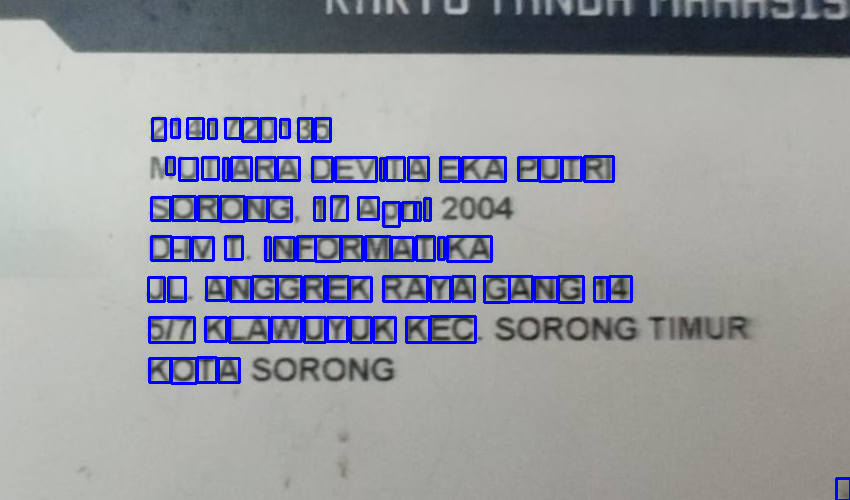

Resized Image Shape: (28, 21)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (15, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 19)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 17)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 22)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 16)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 23)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 23)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 16)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (27, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 10)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 23)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (17, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 22)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (27, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 21)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 10)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (21, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (27, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 18)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 23)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 20)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 15)
Filled Image Shape: (28, 27)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 21)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 21)
Filled Image Shape: (28, 27)


Resized Image Shape: (16, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 9)
Filled Image Shape: (28, 27)


Resized Image Shape: (15, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 21)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 22)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 12)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 23)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 11)
Filled Image Shape: (28, 27)


Resized Image Shape: (16, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 11)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (15, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (15, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (27, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (27, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (22, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 18)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 18)
Filled Image Shape: (28, 28)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', 'Y', 'Z']
3/3 [==============================] - 0s 10ms/step
J K M D S 2 9 L 0 9 U 0 U 2 V T R T K A 1 A 0 1 T T U N A 2 N G R O 1 G W N G A 9 K 3 U A D 1 0 5 Y E T E R K U B M K 1 M P T A P K A 1 T 1 E Y 1 E M A H G A P N U G T M 8 O O 

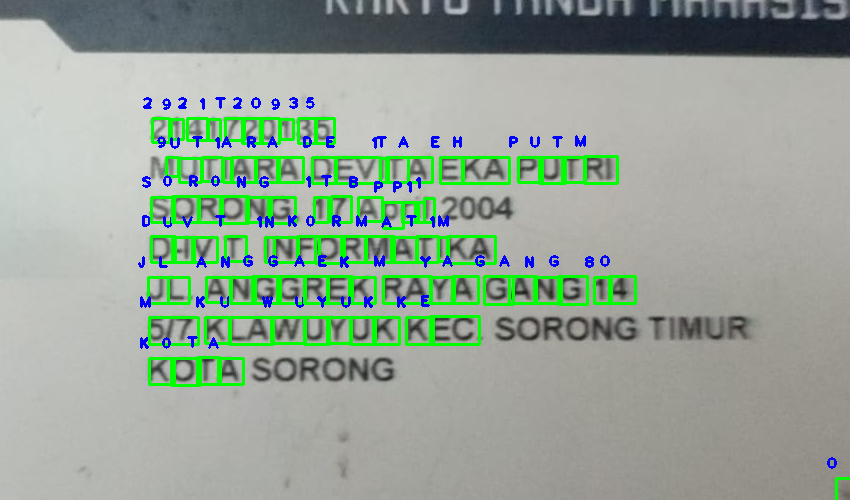

In [ ]:
ocr1(img_p_01)

## **CITRA 2**
### **PREPROCESSING**

In [ ]:
def global_thresholding(image, threshold):
    binary = np.zeros_like(image)
    binary[image > threshold] = 255
    return binary
def cutting(image, x, y, width, height):
    # Crop the region of interest from the image
    hasil = image[y:y+height, x:x+width]
    return hasil
def preprocess_image_2(image_path):
    img = cv2.imread(image_path)
    # Display the original image
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Tentukan koordinat untuk crop
    x, y, width, height = 540, 250, 560, 300

    img = cutting(img, x, y, width, height)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.subplot(2, 3, 2)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    # Apply Global Threshold
    global_threshold = global_thresholding(gray, 135)
    plt.subplot(2, 3, 3)
    plt.imshow(global_threshold, cmap='gray')
    plt.title('Global Threshold')
    plt.axis('off')

    #Erosi the image
    erode_ktp = cv2.erode(global_threshold.copy(), cv2.getStructuringElement(cv2.MORPH_OPEN, (2, 2)))
    plt.subplot(2, 3, 4)
    plt.imshow(erode_ktp, cmap='gray')
    plt.title('Erosi Image')
    plt.axis('off')

    # Invert the image
    invertion = 255 - erode_ktp
    plt.subplot(2, 3, 5)
    plt.imshow(invertion, cmap='gray')
    plt.title('Invertion Image')
    plt.axis('off')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    return img, gray, invertion

### **SEGMENTASI**

In [ ]:
def ocr2(image_path):
    img, gray, invertion = preprocess_image_1(image_path)

    min_w, max_w = 3, 50
    min_h, max_h = 15, 50

    conts = find_contours(invertion.copy())
    process_contours(conts, invertion, img, min_w, max_w, min_h, max_h)

    detected_char = detect_characters(conts, invertion, min_w, max_w, min_h, max_h)

    pixels = np.array([px[0] for px in detected_char], dtype='float32')
    boxes = [box[1] for box in detected_char]

    digits = '0123456789'
    letters = 'ABCDEFGHIJKLMNOPQRSTUVWZYZ'
    char_list = digits + letters
    char_list = [ch for ch in char_list]

    print(char_list)

    # Predict
    preds = load_network.predict(pixels)

    preds.shape

    # Char Prediction
    for p in preds:
      char_idx = np.argmax(p)
      print(char_list[char_idx], end = " ")

    # Show char with actual image
    img_copy2 = img.copy()

    for(pred, (x, y, w, h)) in zip(preds, boxes):
      i = np.argmax(pred)
      char_detected = char_list[i]

      cv2.rectangle(img_copy2, (x, y), (x+w, y+h), (0,255,0), 2)
      cv2.putText(img_copy2, char_detected, (x - 10, y - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 2)

    cv2_imshow(img_copy2)

### **Penerapan OCR pada Citra 2**

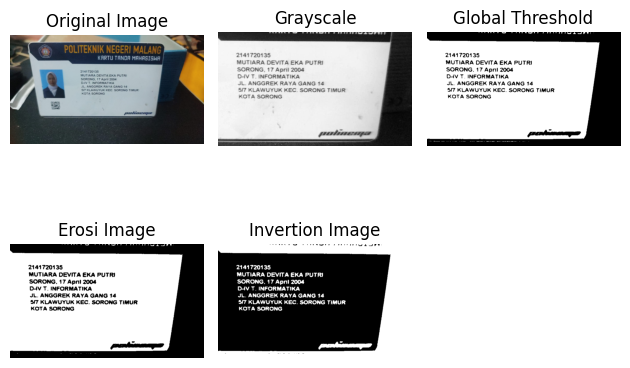

In [ ]:
image_p_02 = '/content/drive/MyDrive/PCVK_KTM/3G_2141720135_2 - MUTIARA DEVITA EKA PUTRI.jpeg'
Preprocess = preprocess_image_1(image_p_02)

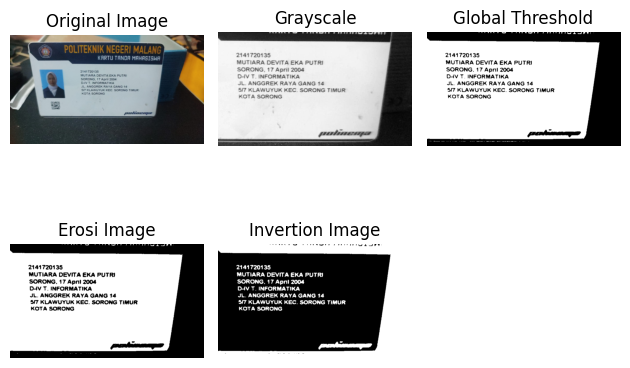

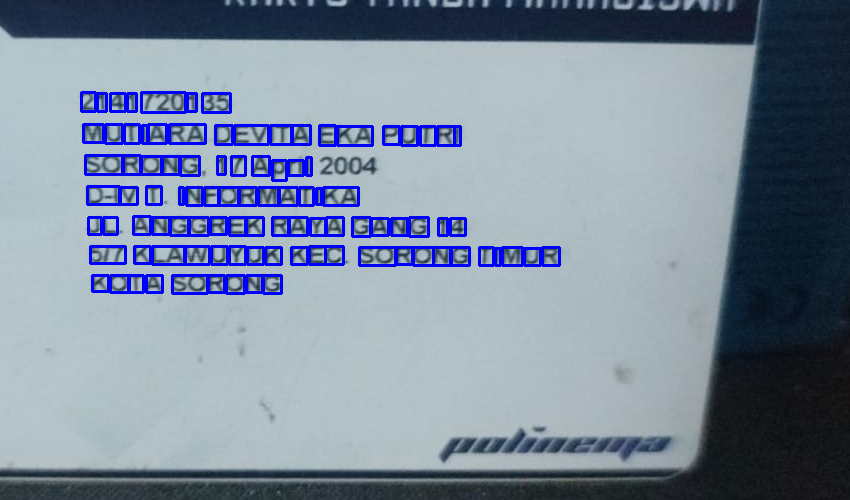

Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (23, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (14, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (15, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (13, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 18)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (24, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 18)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (23, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (12, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 12)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (15, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (14, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (14, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 11)
Filled Image Shape: (28, 27)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (20, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 18)
Filled Image Shape: (28, 28)


Resized Image Shape: (24, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (18, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 16)
Filled Image Shape: (28, 28)


Resized Image Shape: (24, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (15, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (23, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (23, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 22)
Filled Image Shape: (28, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 12)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 14)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (14, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (15, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (14, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (23, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 19)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 13)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 13)
Filled Image Shape: (28, 27)


Resized Image Shape: (23, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', 'Y', 'Z']
4/4 [==============================] - 0s 14ms/step
2 M 2 W J M K 1 L U 0 4 V R T 9 8 A K 0 M 1 B T A U N N M G 2 1 G W N 9 G B F R R U D 9 0 0 Y E T E R N K U A M G K T R P A N A K A T 1 E Y 1 E W E A M G 2 R P N R U G 0 T N R 9 2 G Y T 1 M U R 

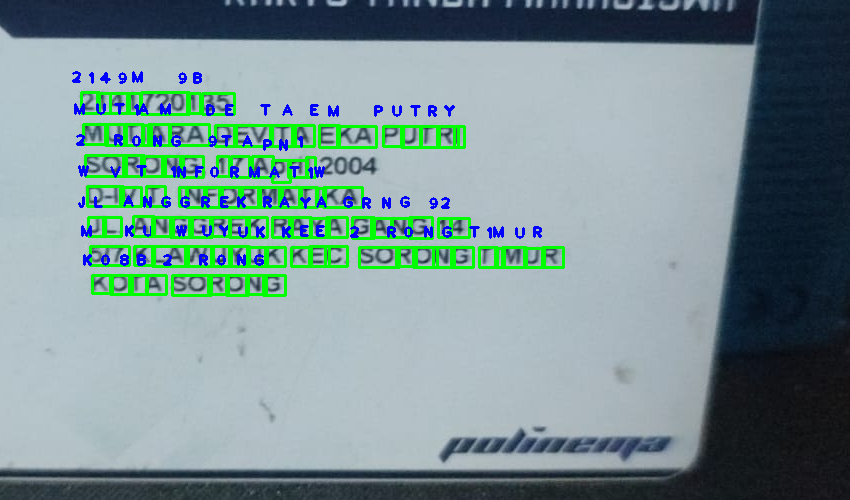

In [ ]:
ocr2(image_p_02)

## **CITRA 3**
### **PREPROCESSING**

In [ ]:
def global_thresholding(image, threshold):
    binary = np.zeros_like(image)
    binary[image > threshold] = 255
    return binary
def cutting(image, x, y, width, height):
    # Crop the region of interest from the image
    hasil = image[y:y+height, x:x+width]
    return hasil

def preprocess_image_3(image_path):
    img = cv2.imread(image_path)
    # Display the original image
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Tentukan koordinat untuk crop
    x, y, width, height = 600, 260, 700, 350

    img = cutting(img, x, y, width, height)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.subplot(2, 3, 2)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    # Apply Global Threshold
    global_threshold = global_thresholding(gray, 148)
    plt.subplot(2, 3, 2)
    plt.imshow(global_threshold, cmap='gray')
    plt.title('Global Threshold')
    plt.axis('off')

    # Erosi the image
    erode_ktp = cv2.erode(global_threshold.copy(), cv2.getStructuringElement(cv2.MORPH_OPEN, (2, 2)))
    plt.subplot(2, 3, 4)
    plt.imshow(erode_ktp, cmap='gray')
    plt.title('Erosi Image')
    plt.axis('off')

    # Invert the image
    invertion = 255 - erode_ktp
    plt.subplot(2, 3, 5)
    plt.imshow(invertion, cmap='gray')
    plt.title('Invertion Image')
    plt.axis('off')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    return img, gray, invertion

### **SEGMENTASI**

In [ ]:
def ocr3(image_path):
    img, gray, invertion = preprocess_image_3(image_path)

    min_w, max_w = 10, 160
    min_h, max_h = 15, 140

    conts = find_contours(invertion.copy())
    process_contours(conts, invertion, img, min_w, max_w, min_h, max_h)

    detected_char = detect_characters(conts, invertion, min_w, max_w, min_h, max_h)

    pixels = np.array([px[0] for px in detected_char], dtype='float32')
    boxes = [box[1] for box in detected_char]

    digits = '0123456789'
    letters = 'ABCDEFGHIJKLMNOPQRSTUVWZYZ'
    char_list = digits + letters
    char_list = [ch for ch in char_list]

    print(char_list)

    # Predict
    preds = load_network.predict(pixels)

    # check shape -> JTI POLINEMA --> shoud be 11 (from 0 to 10)
    preds.shape

    # Char Prediction
    for p in preds:
      char_idx = np.argmax(p)
      print(char_list[char_idx], end = " ")

    # Show char with actual image
    img_copy2 = img.copy()

    for(pred, (x, y, w, h)) in zip(preds, boxes):
      i = np.argmax(pred)
      char_detected = char_list[i]

      cv2.rectangle(img_copy2, (x, y), (x+w, y+h), (0,255,0), 2)
      cv2.putText(img_copy2, char_detected, (x - 10, y - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 2)

    cv2_imshow(img_copy2)

### **Penerapan OCR pada Citra 3**

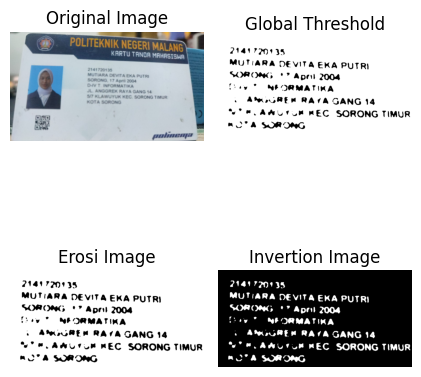

In [ ]:
image_p_03 = '/content/drive/MyDrive/PCVK_KTM/3G_2141720135_3 - MUTIARA DEVITA EKA PUTRI.jpeg'
Preprocess = preprocess_image_3(image_p_03)

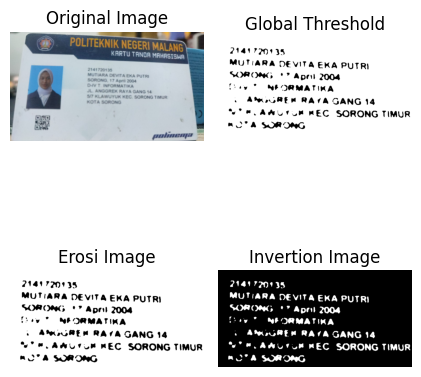

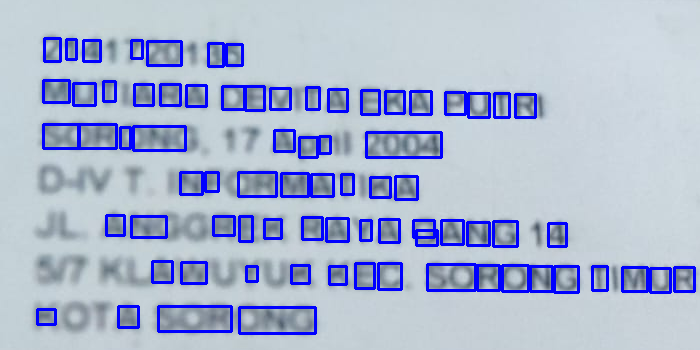

Resized Image Shape: (21, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (18, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (22, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 22)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 17)
Filled Image Shape: (28, 27)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (17, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 20)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 17)
Filled Image Shape: (28, 27)


Resized Image Shape: (16, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 21)
Filled Image Shape: (28, 27)


Resized Image Shape: (13, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (19, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (9, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (22, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 22)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 21)
Filled Image Shape: (28, 27)


Resized Image Shape: (23, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (17, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (9, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 17)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (22, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 19)
Filled Image Shape: (28, 27)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 22)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 20)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 23)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 19)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 23)
Filled Image Shape: (28, 27)


Resized Image Shape: (9, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 27)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (21, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (19, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (15, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (27, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 20)
Filled Image Shape: (28, 28)


Resized Image Shape: (26, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 20)
Filled Image Shape: (28, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', 'Y', 'Z']
3/3 [==============================] - 0s 10ms/step
A 4 M 2 9 U M 0 8 2 2 1 U T M R M 2 W A U H R R 8 A D 3 M M K E T H V A M H D A T A 8 A A A 8 E Y E M H C A K A A Y U W A P N U R 0 T 0 R N O G Y M U R 

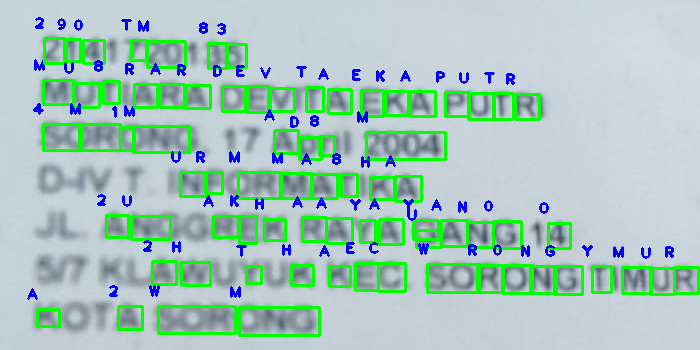

In [ ]:
ocr3(image_p_03)

## **CITRA 4**
### **PREPROCESSING**

In [ ]:
def global_thresholding(image, threshold):
    binary = np.zeros_like(image)
    binary[image > threshold] = 255
    return binary

def cutting(image, x, y, width, height):
    # Crop the region of interest from the image
    hasil = image[y:y+height, x:x+width]
    return hasil

def preprocess_image_4(image_path):
    img = cv2.imread(image_path)
    # Display the original image
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Tentukan koordinat untuk crop
    x, y, width, height = 780, 270, 500, 330

    img = cutting(img, x, y, width, height)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.subplot(2, 3, 2)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    # Apply Global Threshold
    global_threshold = global_thresholding(gray, 145)
    plt.subplot(2, 3, 4)
    plt.imshow(global_threshold, cmap='gray')
    plt.title('Global Threshold')
    plt.axis('off')

    # Erosi the image
    erode_ktp = cv2.erode(global_threshold.copy(), cv2.getStructuringElement(cv2.MORPH_OPEN, (2, 2)))
    plt.subplot(2, 3, 5)
    plt.imshow(erode_ktp, cmap='gray')
    plt.title('Erosi Image')
    plt.axis('off')

    # Invert the image
    invertion = 255 - erode_ktp
    plt.subplot(2, 3, 6)
    plt.imshow(invertion, cmap='gray')
    plt.title('Invertion Image')
    plt.axis('off')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    return img, gray, invertion

### **SEGMENTASI**

In [ ]:
def ocr4(image_path):
    img, gray, invertion = preprocess_image_4(image_path)

    min_w, max_w = 16, 50
    min_h, max_h = 25, 50

    conts = find_contours(invertion.copy())
    process_contours(conts, invertion, img, min_w, max_w, min_h, max_h)

    detected_char = detect_characters(conts, invertion, min_w, max_w, min_h, max_h)

    pixels = np.array([px[0] for px in detected_char], dtype='float32')
    boxes = [box[1] for box in detected_char]

    digits = '0123456789'
    letters = 'ABCDEFGHIJKLMNOPQRSTUVWZYZ'
    char_list = digits + letters
    char_list = [ch for ch in char_list]

    print(char_list)

    # Predict
    preds = load_network.predict(pixels)

    # check shape -> JTI POLINEMA --> shoud be 11 (from 0 to 10)
    preds.shape

    # Char Prediction
    for p in preds:
      char_idx = np.argmax(p)
      print(char_list[char_idx], end = " ")

    # Show char with actual image
    img_copy2 = img.copy()

    for(pred, (x, y, w, h)) in zip(preds, boxes):
      i = np.argmax(pred)
      char_detected = char_list[i]

      cv2.rectangle(img_copy2, (x, y), (x+w, y+h), (0,255,0), 2)
      cv2.putText(img_copy2, char_detected, (x - 10, y - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 2)

    cv2_imshow(img_copy2)

### **Penerapan OCR pada Citra 4**

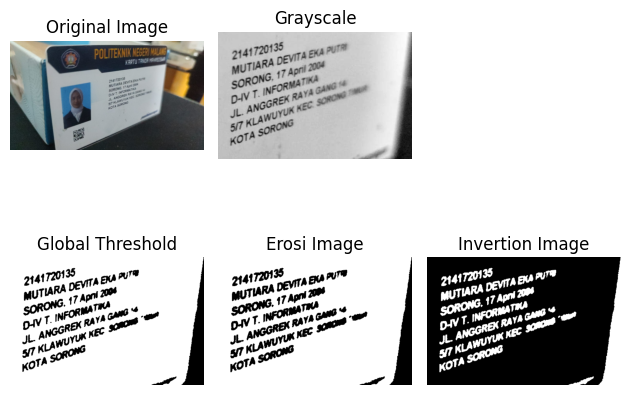

In [ ]:
image_p_04 = '/content/drive/MyDrive/PCVK_KTM/3G_2141720135_4 - MUTIARA DEVITA EKA PUTRI.jpeg'
Preprocess = preprocess_image_4(image_p_04)

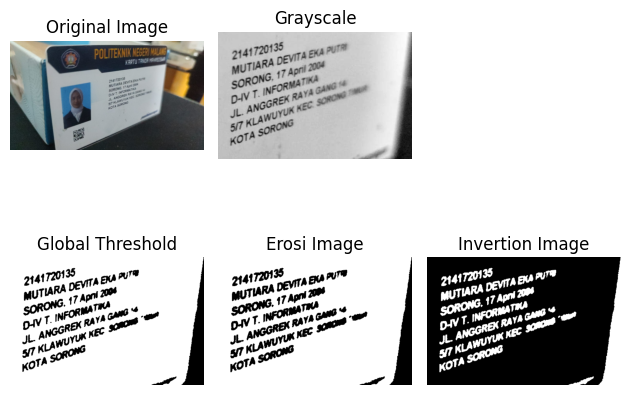

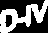

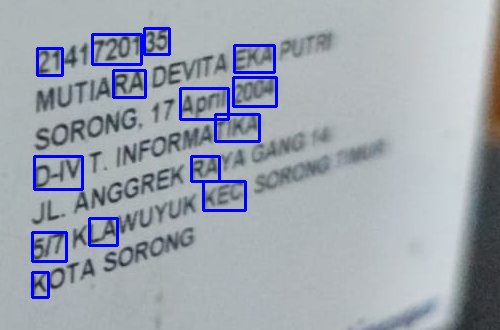

Resized Image Shape: (28, 20)
Filled Image Shape: (28, 28)


Resized Image Shape: (22, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (18, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (16, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (22, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (27, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (17, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (23, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (18, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (16, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (18, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (18, 28)
Filled Image Shape: (28, 28)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', 'Y', 'Z']
1/1 [==============================] - 0s 33ms/step
W D M M U M M B M M M M M W 

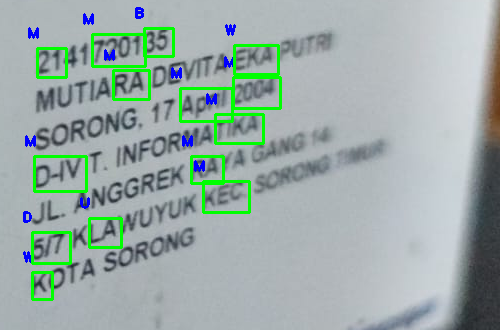

In [ ]:
ocr4(image_p_04)

## **CITRA 5**
### **PREPROCESSING**

In [ ]:
def global_thresholding(image, threshold):
    binary = np.zeros_like(image)
    binary[image > threshold] = 255
    return binary

def cutting(image, x, y, width, height):
    # Crop the region of interest from the image
    hasil = image[y:y+height, x:x+width]
    return hasil

def preprocess_image_5(image_path):
    img = cv2.imread(image_path)
    # Display the original image
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Tentukan koordinat untuk crop
    x, y, width, height = 550, 270, 530, 400

    img = cutting(img, x, y, width, height)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.subplot(2, 3, 2)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    # Apply Global Threshold
    global_threshold = global_thresholding(gray, 145)
    plt.subplot(2, 3, 4)
    plt.imshow(global_threshold, cmap='gray')
    plt.title('Global Threshold')
    plt.axis('off')

    # Erosi the image
    erode_ktp = cv2.erode(global_threshold.copy(), cv2.getStructuringElement(cv2.MORPH_OPEN, (2, 2)))
    plt.subplot(2, 3, 5)
    plt.imshow(erode_ktp, cmap='gray')
    plt.title('Erosi Image')
    plt.axis('off')

    # Invert the image
    invertion = 255 - erode_ktp
    plt.subplot(2, 3, 6)
    plt.imshow(invertion, cmap='gray')
    plt.title('Invertion Image')
    plt.axis('off')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    return img, gray, invertion

### **SEGMENTASI**

In [ ]:
def ocr5(image_path):
    img, gray, invertion = preprocess_image_5(image_path)

    min_w, max_w = 16, 50
    min_h, max_h = 25, 50

    conts = find_contours(invertion.copy())
    process_contours(conts, invertion, img, min_w, max_w, min_h, max_h)

    detected_char = detect_characters(conts, invertion, min_w, max_w, min_h, max_h)

    pixels = np.array([px[0] for px in detected_char], dtype='float32')
    boxes = [box[1] for box in detected_char]

    digits = '0123456789'
    letters = 'ABCDEFGHIJKLMNOPQRSTUVWZYZ'
    char_list = digits + letters
    char_list = [ch for ch in char_list]

    print(char_list)

    # Predict
    preds = load_network.predict(pixels)

    # check shape -> JTI POLINEMA --> shoud be 11 (from 0 to 10)
    preds.shape

    # Char Prediction
    for p in preds:
      char_idx = np.argmax(p)
      print(char_list[char_idx], end = " ")

    # Show char with actual image
    img_copy2 = img.copy()

    for(pred, (x, y, w, h)) in zip(preds, boxes):
      i = np.argmax(pred)
      char_detected = char_list[i]

      cv2.rectangle(img_copy2, (x, y), (x+w, y+h), (0,255,0), 2)
      cv2.putText(img_copy2, char_detected, (x - 10, y - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 2)

    cv2_imshow(img_copy2)

### **Penerapan OCR pada Citra 4**

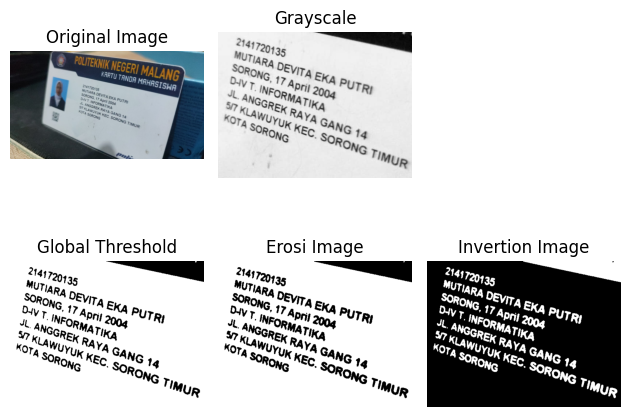

In [ ]:
image_p_05 = '/content/drive/MyDrive/PCVK_KTM/3G_2141720135_5 - MUTIARA DEVITA EKA PUTRI.jpeg'
Preprocess = preprocess_image_5(image_p_05)

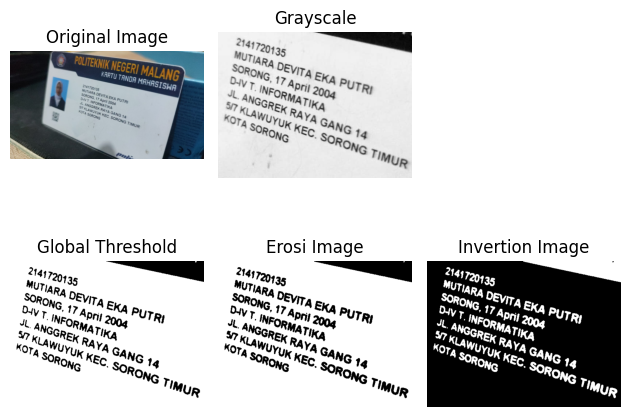

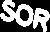

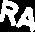

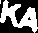

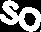

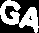

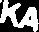

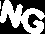

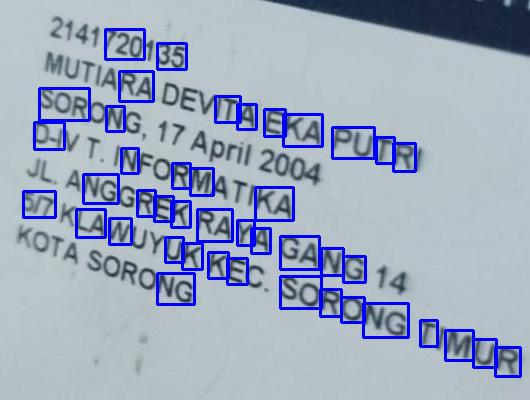

Resized Image Shape: (21, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (23, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (17, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (25, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (22, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (20, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 22)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (23, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 21)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 22)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 23)
Filled Image Shape: (28, 27)


Resized Image Shape: (22, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (23, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 22)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 23)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 22)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (24, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (27, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 21)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 23)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 23)
Filled Image Shape: (28, 27)


Resized Image Shape: (23, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (21, 28)
Filled Image Shape: (27, 28)


Resized Image Shape: (22, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (22, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (20, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


Resized Image Shape: (20, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 22)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 24)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 21)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 28)
Filled Image Shape: (28, 28)


Resized Image Shape: (28, 25)
Filled Image Shape: (28, 27)


Resized Image Shape: (28, 26)
Filled Image Shape: (28, 28)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', 'Y', 'Z']
2/2 [==============================] - 0s 7ms/step
W U M U M M H W M N R E M 5 U K Z K M M K N E Y A A U E Q U K K N M A G M T R T M U R 

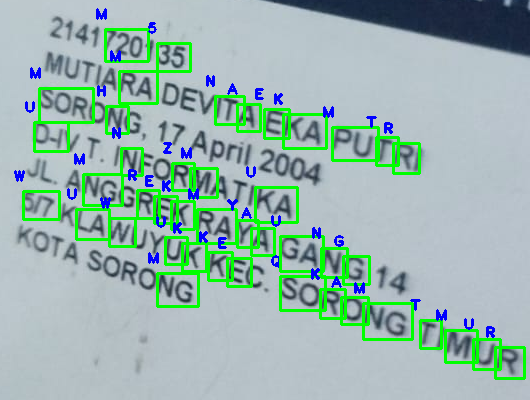

In [ ]:
ocr5(image_p_05)